In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.neighbors import RadiusNeighborsRegressor

import copy

import ffrd_data_utils as fdu

In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39597,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:32813,Total threads: 3
Dashboard: http://127.0.0.1:34107/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:37347,


In [3]:
RADIUS = 125

In [4]:
df = pd.read_parquet('./data/parquet/Addison_M03_H04_E4001.p01.hdf.center.parquet')
ras_cell_coords = df[['x', 'y']].values
df

,x,y,wsel_max,wsel_min
0,1.085386e+06,1.928431e+06,687.012085,687.012085
1,1.085486e+06,1.928431e+06,685.290344,685.290344
2,1.085586e+06,1.928431e+06,684.875061,684.875061
3,1.085186e+06,1.928331e+06,687.055847,687.055847
4,1.085286e+06,1.928331e+06,686.137634,686.137634
...,...,...,...,...
85192,1.106179e+06,1.913128e+06,646.625000,646.625000
85193,1.084537e+06,1.908434e+06,673.996460,673.996460
85194,1.084885e+06,1.905620e+06,669.905029,669.905029
85195,1.116012e+06,1.887121e+06,622.114746,622.114746


In [5]:
wsel_ds = xr.open_dataset('./data/wsel_quantiles.zarr')
wsel_ds

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:   (aep: 8, index: 85197)
Coordinates:
  * aep       (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
  * index     (index) int64 0 1 2 3 4 5 ... 85191 85192 85193 85194 85195 85196
Data variables:
    lower_ci  (aep, index) float32 ...
    upper_ci  (aep, index) float32 ...
    wsel      (aep, index) float32 ...

In [6]:
wsel_da = wsel_ds['wsel']
wsel_da

<xarray.DataArray 'wsel' (aep: 8, index: 85197)>
[681576 values with dtype=float32]
Coordinates:
  * aep      (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
  * index    (index) int64 0 1 2 3 4 5 6 ... 85191 85192 85193 85194 85195 85196

In [7]:
terrain_da = fdu.load_terrain('./data/terrain/Terrain_Addison_M03.tif')
terrain_da

<xarray.DataArray (y: 8899, x: 10249)>
dask.array<getitem, shape=(8899, 10249), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
    spatial_ref  int64 0
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [8]:
n_chunks = 2
chunk_width = 512
x_start = 0
y_start = 0
x_size = chunk_width * n_chunks
y_size = chunk_width * n_chunks
x_end = x_start + x_size
y_end = y_start + y_size
y_slice = slice(y_start, y_start + chunk_width * n_chunks)
da_template = xr.DataArray(np.empty((len(wsel_da.aep), y_size, x_size)), dims=['aep', 'y', 'x'],
                           attrs=terrain_da.attrs, coords={
    'y': terrain_da.y[x_start:x_end],
    'x': terrain_da.x[y_start:y_end],
    'aep': wsel_ds.aep,
    'spatial_ref': terrain_da.spatial_ref,
}).chunk({'x': chunk_width,'y': chunk_width,  'aep': len(wsel_ds.aep)})
da_template

<xarray.DataArray (aep: 8, y: 1024, x: 1024)>
dask.array<xarray-<this-array>, shape=(8, 1024, 1024), dtype=float64, chunksize=(8, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.924e+06 1.924e+06
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.086e+06 1.086e+06
  * aep          (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
    spatial_ref  int64 0
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [9]:
from sklearn.neighbors import KDTree

# Define KDTree with your data points 
tree = KDTree(ras_cell_coords)  # X is your array of points [n_samples, n_features]

def select_nearest_points(coords, radius, aep):
    """Selects nearest data points for given coordinates within a specified radius."""

    # Indices of the points within radius for each coord
    nearest = tree.query_radius(coords, r=radius)
    ind = np.unique(np.concatenate(nearest))

    # If no points are found, return empty arrays
    if len(ind) == 0:
        return np.empty((0, 2)), np.empty((0,))

    # If only one point is found, return it
    elif len(ind) == 1:
        nearest_point = ras_cell_coords[ind]
        nearest_value = wsel_da.sel(index=ind, aep=aep).values[0]
        if np.isnan(nearest_value):
            return np.empty((0, 2)), np.empty((0,))
        return [nearest_point], [nearest_value]

    # Select the nearest points and their corresponding values
    nearest_points = ras_cell_coords[ind]
    nearest_values = wsel_da.sel(index=ind, aep=aep).values

    # Remove points with NaN values
    nearest_points = nearest_points[~np.isnan(nearest_values)]
    nearest_values = nearest_values[~np.isnan(nearest_values)]

    return nearest_points, nearest_values

In [18]:
def interpolate_block(block: xr.DataArray):
    result_da = block.expand_dims({'aep': wsel_da.aep.values}).copy()

    # load terrain in order to calculate depth / extent
    block_terrain = terrain_da.sel(x=block.x, y=block.y)

    # loop through all AEPs
    for i, aep in enumerate(wsel_da.aep.values):
        # get list of all coordinate combinations in the block
        block_x_coords = block.coords['x'].values
        block_y_coords = block.coords['y'].values
        block_coords = np.array([(x, y) for y in block_y_coords for x in block_x_coords])
        nearest_coords, nearest_wsel = select_nearest_points(block_coords, RADIUS * 3, aep)

        # if no points are found, return a block full of NaNs
        if len(nearest_coords) == 0:
            result_da.values[i, :, :] = np.full(block.shape, np.nan)

        else:
            # train IDW model with selected points
            idw = RadiusNeighborsRegressor(radius=RADIUS, weights='distance', algorithm='auto').fit(nearest_coords, nearest_wsel)

            # use IDW model to predict for all coordinates in the block
            result = idw.predict(block_coords).reshape(block.shape)

            # return areas where depth > 0
            depth = result - block_terrain.values
            result_da.values[i, :, :] = np.where(depth > 0, result, np.nan)

    return result_da

In [19]:
result_da = terrain_da.isel(x=slice(x_start, x_end), y=slice(y_start, y_end)).map_blocks(interpolate_block, template=da_template)
result_da

<xarray.DataArray (aep: 8, y: 1024, x: 1024)>
dask.array<<this-array>-interpolate_block, shape=(8, 1024, 1024), dtype=float64, chunksize=(8, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.924e+06 1.924e+06
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.086e+06 1.086e+06
  * aep          (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
    spatial_ref  int64 dask.array<chunksize=(), meta=np.ndarray>
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [20]:
result_da = result_da.compute()
result_da

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


<xarray.DataArray (aep: 8, y: 1024, x: 1024)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ..., 689.68085, 689.67645,
         689.669  ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ..., 689.78986, 689.78436,
         689.7673 ],
        [      nan,       nan,       nan, ...,       nan,       nan,
         689.7566 ]]], dtype=float32)
Coordinates:
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.924e+06 1.924e+06
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.086e+06 1.086e+06
  * aep          (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
    spatial_ref  int64 0
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

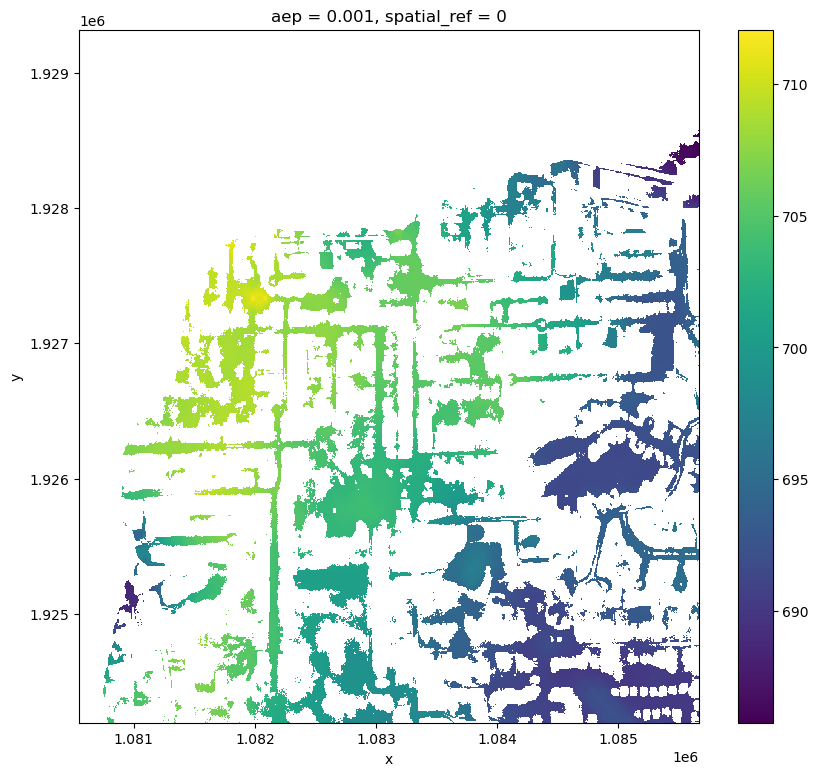

In [24]:
result_da.sel(aep=0.001).plot(figsize=(10, 9))

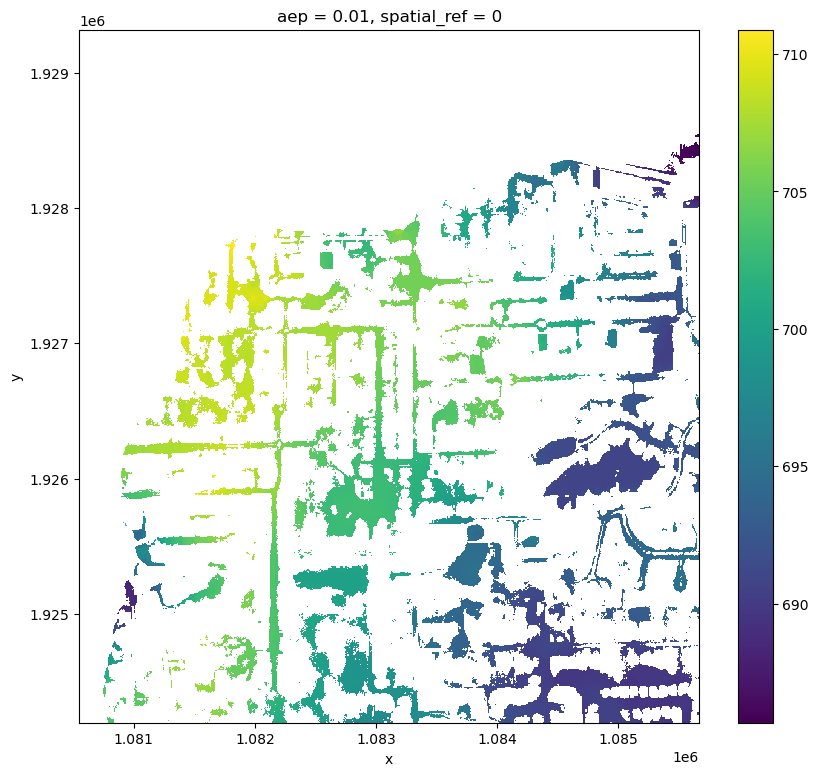

In [25]:
result_da.sel(aep=0.01).plot(figsize=(10, 9))

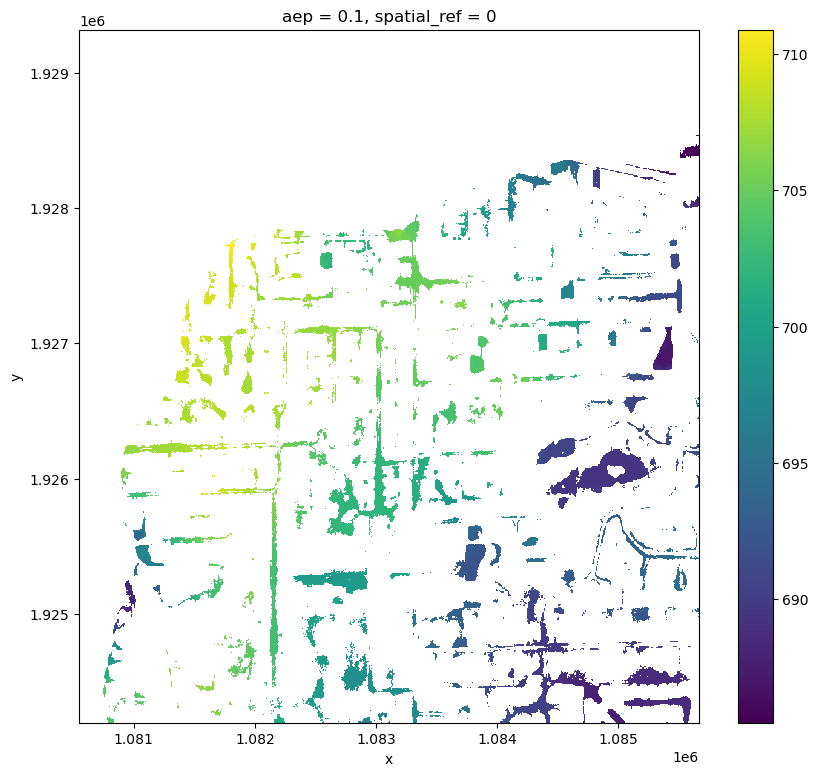

In [26]:
result_da.sel(aep=0.1).plot(figsize=(10, 9))